# Solving a one-asset HANK model in sequence space
In this notebook we show how to
1. [Set up a heterogenous agent block](#1-hetblock)
2. [Solve for a steady state with multiple calibration targets](#2-calibration)
3. [Compute the Jacobian almost automatically via helper functions](#3-jacobian)
4. [Compute linearized impulse responses](#4-linear)
5. [Compute nonlinear impulse responses](#5-nonlinear)
6. [Check local determinacy](#6-determinacy)

This notebook accompanies work in progress by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## Model description
The model is a HA version of the textbook New Keynesian model. Technology is linear in labor, prices are sticky á la Rotemberg, and monetary policy follows a Taylor rule. For a detailed description of the model, please see the slides. As a reminder, the model can be summarized in sequence form as

$$
\textbf{H}_t(\textbf{Y}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots
$$

where the endogenous variables are $\textbf{Y} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$. 

The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation

$$
\begin{align}
V_t(e, a_{-}) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a) \mathcal{P}(e,e') \right\}
\\
c + a &= (1 + r_t)a_{-} + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a &\geq 0
\end{align}
$$

where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends. 

We can think of the model as a directed acyclical graph (DAG) with **3 endogenous inputs**  

![Directed Acyclical Graph](figures/hank_dag.png) 

and write it as an implicit function

$$
H(\pi, Y, w; \epsilon, Z) = 0.
$$

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import het_block as het
import rec_block as rec
from rec_block import recursive
import jacobian as jac
import solvers
import hank

<a id="1-hetblock"></a>

## 1 Set up heterogeneous-agent block
The main task here is to write a **backward iteration function** that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration. For the standard income fluctuation problem with endogenous labor supply we're dealing with here, the endogenous gridpoint method of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.

Solving this problem via EGM is standard but somewhat tedious and so the details are left to ``hank.py``. Let's pick up the thread right after the backward iteration had been defined. Note that `hank.solve_cn` is the routine that computes optimal consumption and labor supply decision of borrowing constrained agents. This is a self-contained, static problem that we precompute and supply to backward iteration. 

As in the Krusell-Smith notebook, we can now solve for the steady state policy functions by repeatedly applying the backward iteration function until convergence. 

In [2]:
from hank import backward_iterate_labor, solve_cn

def pol_labor_ss(Pi, a_grid, e_grid, T, w, r, beta, eis, frisch, vphi, Va_seed=None, tol=1E-8, maxit=5000):
    """Solve for steady-state policy functions

    Parameters
    ----------
    Pi       : array (S*S), Markov matrix for skills
    a_grid   : array (A), asset grid
    e_grid   : array (S), skill grid
    T        : array (S*A), transfer income (dividends - taxes)
    w        : scalar, real wage
    r        : scalar, ex-post real interest rate
    beta     : scalar, discount rate
    eis      : scalar, elasticity of intertemporal substitution
    frisch   : scalar, Frisch elasticity of labor supply
    Va_seed  : array (S*A) [optional], starting value for backward variable
    tol      : scalar [optional], tolerance level
    maxit    : int [optional], maximum number of backward iterations

    Returns
    ----------
    Va      : array (S*A), marginal value of assets (backward variable)
    a       : array (S*A), asset policy
    c       : array (S*A), consumption policy
    n       : array (S*A), labor supply policy
    ns      : array (S*A), effective labor supply policy
    c_const : array (S*A), consumption policy of constrained households 
    n_const : array (S*A), labor supply policy of constrained households 
    """
    if Va_seed is None:
        coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
        Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    else:
        Va = Va_seed

    # precompute constrained c and n which don't depend on Va
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    c_const, n_const = solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)

    # iterate until convergence of a policy by tol or reach max number of iterations
    a = np.empty_like(Va)
    for it in range(maxit):
        Va, anew, c, n, ns = backward_iterate_labor(Va, Pi, a_grid, e_grid, T, w, r, beta, eis, frisch, vphi,
                                                         c_const, n_const, ssflag=True)

        if it % 10 == 1 and utils.within_tolerance(a, anew, tol):
            break
        a = anew
    else:
        raise ValueError(f'No convergence after {maxit} backward iterations!')

    return Va, a, c, n, ns, c_const, n_const

Next, we use the steady state policies to compute the stationary distribution. As we mentioned in the Krusell-Smith notebook, this code is generic for models with one endogenous state. In particular, it applies to the model with endogenous labor supply directly.

Now we're ready to put all these steps together in a single function, which gives the complete partial equilibrium behavior of the household sector in steady state: when fed with the Markov transition matrix, the grids, the interest rate, and so on, it gives the steady-state distribution, aggregate and individual policies, and so on.

In [3]:
def household_labor_ss(Pi, a_grid, e_grid, T, w, r, beta, eis, frisch, vphi, Va_seed=None, D_seed=None, pi_seed=None):
    """Solve for steady-state policies and distribution. Report results in dict."""
    # solve ha block
    Va, a, c, n, ns, c_const, n_const = pol_labor_ss(Pi, a_grid, e_grid, T, w, r, beta, eis, frisch, vphi, Va_seed)
    D = utils.dist_ss(a, Pi, a_grid, D_seed, pi_seed)

    # return handy dict with results and inputs
    inputs = {'Pi': Pi, 'a_grid': a_grid, 'e_grid': e_grid, 'T': T, 'w': w, 'r': r, 'beta': beta, 'eis': eis,
              'frisch': frisch, 'vphi': vphi}
    results = {'D': D, 'Va': Va, 'a': a, 'c': c, 'n': n, 'ns': ns, 'c_const': c_const, 'n_const': n_const,
               'A': np.vdot(D, a), 'C': np.vdot(D, c), 'N': np.vdot(D, n), 'NS': np.vdot(D, ns)}

    return {**inputs, **results}

<a id="2-calibration"></a>

## 2 Calibrating the steady state
Next, we embed this HA block in general equilibrium. We calibrate the discount factor $\beta$ and disutility of labor $\varphi$ to hit quarterly interest rate $r=0.005$ (approx. 2% annually) and total effective labor $L=1.$

This is a two-dimensional rootfinding problem that we solve by Broyden's method which we implemented in ``solvers.py``. it takes a function $f: \mathbb{R}^n \to \mathbb{R}^n$ and an initial guess for its roots, $x_0 \in \mathbb{R}^n.$ The user can  define a set of invalid inputs from which the solver backtracks. This useful feature is the main reason for implementing our own routine.

The calibration has two substantive steps. First, express analytically all variables that don't depend on $(\beta, \varphi).$ Second, construct the residual function that takes the current guesses $(\beta, \varphi)$ and maps them into deviations from he calibration targets. This just requires an evaluation of the household block. The rootfinder does the rest. 

Although additional efficiency gains would be possible here (for instance, by updating our initial guesses for policy and distribution along the way), we will not implement them, since they are not our focus here.

In [4]:
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1.5, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_s, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)

    # default incidence rule is proportional to skill
    if tax_rule is None:
        tax_rule = e_grid  # scale does not matter, will be normalized anyway
    if div_rule is None:
        div_rule = e_grid

    assert tax_rule.shape[0] == div_rule.shape[0] == nS, 'Incidence rules are inconsistent with income grid.'

    # solve analitically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B
    div = Div / np.sum(pi_s * div_rule) * div_rule
    tax = Tax / np.sum(pi_s * tax_rule) * tax_rule
    T = div - tax

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household_labor_ss(Pi, a_grid, e_grid, T, w, r, beta_loc, eis, frisch, vphi_loc)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = solvers.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation to report variables
    ss = household_labor_ss(Pi, a_grid, e_grid, T, w, r, beta, eis, frisch, vphi)
    ss.update({'pi_s': pi_s, 'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'Div': Div, 'Tax': Tax, 'div': div, 'tax': tax, 'div_rule': div_rule, 'tax_rule': tax_rule,
               'goods_mkt': 1 - ss['C'], 'ssflag': False})
    return ss

Let's solve for the steady state using our default calibration, and plot the labor supply policy as function of assets for each skill type. In general, poorer and more productive households choose to work more. 

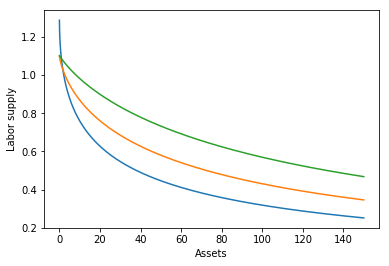

In [5]:
ss = hank_ss(nS=3)
plt.plot(ss['a_grid'], ss['n'].T)
plt.xlabel('Assets'), plt.ylabel('Labor supply')
plt.show()

### Checking Walras's law
It's always a good idea to check whether Walras's law holds. The omitted goods market clearing condition reads simply as 
$$
Y = C
$$
(there are no price-adjustment costs in the zero-inflation steady state) and is reported by the `hank_ss` function above.

In [6]:
print(ss['goods_mkt'])

-2.955806266413674e-09


<a id="3-jacobian"></a>

## 3 Jacobians
Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians which can be combined via the chain rule into Jacobians of full model. A Jacobian in a $T$-dimensional (truncated) sequence space is a $T \times T$ matrix of the form
$$
\frac{d Y}{d Z} = 
\begin{pmatrix}
\frac{d Y_0}{d Z_0} & \frac{d Y_0}{d Z_1} & \dots & \frac{d Y_0}{d Z_T} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{d Y_T}{d Z_0} & \frac{d Y_T}{d Z_1} & \dots & \frac{d Y_T}{d Z_T}
\end{pmatrix}
$$
evaluated at the steady state.

### 3.1 Recursive blocks
Recursive blocks are specified as regular python functions with the decorator ``@recursive``. In the body of the function, we simply implement the corresponding equilibrium conditions. The decorator turns the function into an instance of ``RecursiveBlock``, a simple class with methods to evaluate itself in steady state and along a transition path. Notice that one can write x(-k) and x(+k) to denote k-period lags and leads of some variable x. 

The DAG above has 6 recursive nodes. But it makes sense to consolidate all market clearing conditions in a single block. This leaves us with the following five blocks.

In [7]:
@recursive
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return L, Div

@recursive
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    return r

@recursive
def fiscal(r, B):
    Tax = r * B
    return Tax

@recursive
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc_res

@recursive
def mkt_clearing(A, NS, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NS - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return asset_mkt, labor_mkt, goods_mkt

Let's take a look at the Jacobians of the Phillips curve.

In [8]:
J_nkpc = rec.all_Js(nkpc, ss, T=5, shock_list=['pi', 'w', 'Z', 'Y', 'r'])
print(J_nkpc['nkpc_res']['pi'])
print(J_nkpc['nkpc_res'].keys())

[[-1.          0.99502488  0.          0.          0.        ]
 [ 0.         -1.          0.99502488  0.          0.        ]
 [ 0.          0.         -1.          0.99502488  0.        ]
 [ 0.          0.          0.         -1.          0.99502488]
 [ 0.          0.          0.          0.         -1.        ]]
dict_keys(['pi', 'w', 'Z'])


Notice two things. First, inflation shows up with with a lead as well, so the corresponsing Jacobian is not diagonal, though still sparse. Second, ``J_nkpc`` does not have entries for $(Y, r)$ even though we asked for them. The reason is they have no first-order effect, i.e. their Jacobians are zero. ``rec_block.all_Js`` recognizes this and does return them. This behavior ensures that we won't inadvertently do wasteful computations.   

### 3.2 HA blocks
The Jacobians of HA blocks are analogous objects to the Jacobians of recursive blocks we just saw. They are $T \times T$ matrices linking aggregate inputs to aggregate outputs. We propose an efficient algorithm to compute them. See the Beamer slides and the `het_jacobian.ipynb` notebook for details. 

The algorithm is implemented in `het_block.py`. At the end of the day, we'll be able to call a single function, much like `rec_block.own_jac` above.  The difference is that the shocked inputs have to be specified as a nested dict. This may look like an unnecessarily complicated formulation, but it allows us to use the same, concise ``backward_iteration_labor`` function in any macro model. From the households' perspective, all that matters is what $(r, w, T)$ are. They just take this given, irrespective of how they are determined in the GE. 

So we proceed in two steps. First, compute the derivative of the state-specific transfer income with respect to aggregate dividends and taxes. Second, call ``het.all_Js`` that we used for Krusell-Smith model as well. 

In [9]:
T_div = ss['div_rule'] / np.sum(ss['pi_s'] * ss['div_rule'])
T_tax = -ss['tax_rule'] / np.sum(ss['pi_s'] * ss['tax_rule'])
J_ha = het.all_Js(backward_iterate_labor, ss, 5, {'r': {'r': 1},
                                                  'w': {'w': 1},
                                                  'Div': {'T': T_div},
                                                  'Tax': {'T': T_tax}})

print(J_ha['N']['w'])

[[ 0.41858989 -0.03725707 -0.0334529  -0.0305992  -0.02834089]
 [-0.03746011  0.42478859 -0.03375212 -0.03087963 -0.02851457]
 [-0.03397766 -0.03394634  0.42821848 -0.03123381 -0.02884589]
 [-0.03146171 -0.03138847 -0.03140138  0.4306685  -0.02925065]
 [-0.02945271 -0.02935814 -0.02934221 -0.02940397  0.43260107]]


<a id="4-linear"></a>

## 4 Linearized dynamics using Jacobians
Recall that we reduced the to the following DAG:

![Directed Acyclical Graph](figures/hank_dag.png) 

that can also be written as an implicit equation

$$
H(\pi, Y, w; r^*, Z) =
\begin{pmatrix}
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{L}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0\end{pmatrix},
$$

to be solved for $X=(\pi, w, Y)$ given any $(Z, r^*)$. The rest of the endogenous variables are be obtained as explicit functions of $(\pi, w, Y; Z, r^*)$ along the DAG, but it would be tedious to write them out.

Keep in mind that the implicit function theorem implies that

$$
dX = -\left[\frac{dH}{dX}\right]^{-1} \left(\frac{dH}{dr^*} dr^* + \frac{dH}{dZ} dZ\right). \tag{1}
$$

Then the response of other endogenous variables, e.g. consumption,  can be computed as the sum of direct and indirect effects:

$$
dC = \underbrace{\frac{\partial C}{\partial r^*} d r^* + \frac{\partial C}{\partial Z} dZ}_{\text{direct}} + \underbrace{\frac{dC}{dX} dX}_{\text{indirect}}. \tag{2}
$$

### 4.1 Algorithm
We will obtain a linear characterization of all impulse responses that parallels the four-part procedure on page 13 of the beamer slides. In contrast to the simpler Krusell-Smith model, we'll rely more on convenience functions to manipulate Jacobians. This is to simplify the code and minimize errors. 

Recall that we already solved for a steady state and stored is as `ss`. Furthermore, we will use a 300-period truncation horizon. 

#### Step 1: For each block, obtain Jacobians of outputs with respect to inputs
Here, we have six blocks: five recursive blocks and the heterogeneous household block. First, let's define lists with the names of exogenous inputs, endogenous inputs (unknowns), and targets. These will be useful later. Second, let's use `rec.all_Js` to differentiate the 5 recursive blocks with respect to their inputs that can change (so not the parameters). Third, we calculate the Jacobians of the HA household block in two steps as discussed in section 3. 

In [10]:
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# jacobians for simple blocks
J_firm = rec.all_Js(firm, ss, T)
J_monetary = rec.all_Js(monetary, ss, T, ['pi', 'rstar'])
J_fiscal = rec.all_Js(fiscal, ss, T, ['r'])
J_nkpc = rec.all_Js(nkpc, ss, T, ['pi', 'w', 'Z', 'Y', 'r'])
J_mkt = rec.all_Js(mkt_clearing, ss, T, ['A', 'NS', 'C', 'L', 'Y'])

# jacobian of HA block
T_div = ss['div_rule'] / np.sum(ss['pi_s'] * ss['div_rule'])
T_tax = -ss['tax_rule'] / np.sum(ss['pi_s'] * ss['tax_rule'])
J_ha = het.all_Js(backward_iterate_labor, ss, T, {'r': {'r': 1},
                                                  'w': {'w': 1},
                                                  'Div': {'T': T_div},
                                                  'Tax': {'T': T_tax}})

#### Step 2: Compose Jacobians along the computational graph
We're interested in the Jacobians with respect to the inputs of $H$, that means the unknowns $(\pi, w, Y)$ and the shocks $(r^*, Z).$

Manually composing the Jacobians of six blocks would be a tedious and error-prone process. Instead, we're going to use `jac.chain_jacobians` to apply the chain rule to all blocks at once. Note that the **order of blocks in jacdicts matters**: they have follow each other as in the DAG. For example, `J_firm` has to preceed `J_ha`, because the firm block outputs dividends which is an input to the households. The resulting `J` dictionary contains the Jacobian of the outputs of all blocks with respect to the variables in `unknowns` and `exogenous`.  

In [11]:
J = jac.chain_jacobians(jacdicts=[J_firm, J_monetary, J_fiscal, J_ha, J_mkt, J_nkpc],
                        inputs=unknowns+exogenous, T=T)

#### Step 3 and 4: Use the inverse Jacobian $H_X^{-1}$  and the shock-specific multiplier matrices $H_{r^*}, H_Z$ to build all impulses
The convenience functions from `jacobian.py` allow us to implement these seemingly complex operations in just a few lines. First, we assemble the large Jacobian $H_X \in \mathbb{R}^{3T \times 3T}$ using `jac.pack_jacobians`. This matrix captures (to first order) the implicit relationship between unknowns $X=(\pi, w, Y)$ induced by the requirement that markets clear and the Phillips curve holds, i.e. that the targets of the DAG evaluate to zero. Second, we implement equations (1) and (2) by chaining together the $H_X^{-1}$ with $H_{r^*}, H_Z$ and $J.$ The latter is needed for the direct effects.

In [12]:
# assemble large Jacobian
H_X = jac.pack_jacobians(J, unknowns, targets, T)

# calculate H_X^(-1) and H_rstar and H_Z unpacked as jacobian dicts
J_unknowns = jac.unpack_jacobians(-np.linalg.inv(H_X), targets, unknowns, T) # unpacked H_X^(-1)
J_targets = {k: v for k, v in J.items() if k in targets}                     # unpacked H_rstar and H_Z

# get G for everything by chaining these together and then also chaining with J
G = jac.chain_jacobians(jacdicts=[J_targets, J_unknowns, J], inputs=exogenous, T=T)

### 4.2 Results
Let's consider 25 basis point monetary policy shocks with different persistences and plot the response of inflation.

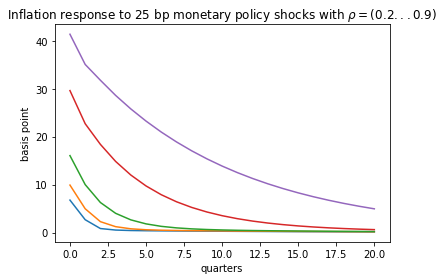

In [13]:
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])
drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
plt.plot(10000 * dpi[:21])
plt.title(r'Inflation response to 25 bp monetary policy shocks with $\rho=(0.2 ... 0.9)$')
plt.xlabel('quarters'); plt.ylabel('basis point')
plt.show()

<a id="5-nonlinear"></a>

## 5. Nonlinear dynamics
Conceptually there's nothing new in this section compared to the Krusell-Smith notebook. We're going to implement a quasi-Newton algorithm to solve for the unknown sequences $X=(\pi, w, Y)$ given some sequences of shocks $(r^*, Z).$ We initialize the algorithm by the naive guess that the variables in $X$ stay constant at their steady-state level. Then we evaluate the DAG and update the guess using the inverse Jacobian $H_X^{-1}.$ The algorithm converges in a few steps, despite the presence of substantial nonlinearities.

The function `td_map` takes these 5 (truncated) sequences of unknowns and shocks and maps them into 3 sequences for the targets of the DAG. Recall that these are the Phillips curve, asset market clearing, and labor market clearing.

In [14]:
def td_map(ss, pi, w, Y, rstar, Z):
    # simple blocks
    L, Div = firm.td(ss, Y=Y, w=w, Z=Z, pi=pi)
    r = monetary.td(ss, pi=pi, rstar=rstar)
    Tax = fiscal.td(ss, r=r)
    div = Div[:, np.newaxis] / np.sum(ss['pi_s'] * ss['div_rule']) * ss['div_rule']
    tax = Tax[:, np.newaxis] / np.sum(ss['pi_s'] * ss['tax_rule']) * ss['tax_rule']

    # ha block
    td = household_td(backward_iterate_labor, ss, T=div-tax, w=w, r=r)
    td.update({'pi': pi, 'w': w, 'Y': Y, 'L': L, 'r': r, 'Div': Div, 'Tax': Tax, 'rstar': rstar, 'Z': Z})

    # nkpc and market clearing
    nkpc_res = nkpc.td(ss, pi=pi, w=w, Y=Y, Z=Z, r=r)
    asset_mkt, labor_mkt, td['goods_mkt'] = mkt_clearing.td(ss, **{k: td[k] for k in ('A', 'NS', 'C', 'L', 'Y', 'pi')})

    return nkpc_res, asset_mkt, labor_mkt, td

Let's put this function into the quasi-Newton algorithm.

In [15]:
def td_nonlinear(ss, J, rstar, Z, tol=1E-8, maxit=30, noisy=True):
    T = rstar.shape[0]

    # assemble large jacobian
    H_X = jac.pack_jacobians(J, inputs=['pi', 'w', 'Y'], outputs=['nkpc_res', 'asset_mkt', 'labor_mkt'], T=T)
    H_X_inv = np.linalg.inv(H_X)

    # initialize guess at ss
    pi = np.full(T, 0)
    w = np.full(T, ss['w'])
    Y = np.full(T, ss['Y'])
    guesses = np.concatenate((pi, w, Y))

    # iterate until convergence
    for it in range(maxit):
        pi, w, Y = guesses[:T], guesses[T:2*T], guesses[2*T:],
        nkpc_res, asset_mkt, labor_mkt, td = td_map(ss, pi, w, Y, rstar, Z)
        residual = np.concatenate((nkpc_res, asset_mkt, labor_mkt))
        error = np.max(np.abs(residual))
        if noisy:
            print(f'Max error {error:.2E} on iteration {it}')
        if error < tol:
            break
        else:
            guesses -= H_X_inv @ residual
    else:
        raise ValueError(f'No convergence after {maxit} backward iterations!')

    return td

### 5.1 A typical monetary policy shock
Note that the linearized solution ignores price adjustment costs. For a monetary policy shock of typical size and persistent, this does not really matter.   

Max error 9.65E-03 on iteration 0
Max error 6.87E-05 on iteration 1
Max error 9.10E-07 on iteration 2
Max error 1.16E-08 on iteration 3
Max error 1.36E-10 on iteration 4


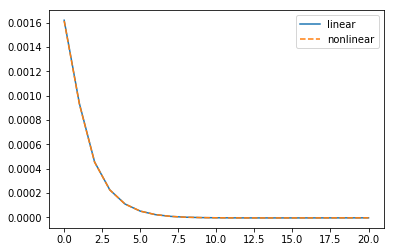

In [16]:
rho_r, sig_r = 0.5, -0.0025
drstar = sig_r * rho_r ** (np.arange(T))

td_lin = hank.td_linear(G, {'rstar': drstar})
td_nonlin = hank.td_nonlinear(ss, J, ss['r'] + drstar, np.full(T, ss['Z']))

plt.plot(td_lin['C'][:21], label='linear', linestyle='-')
plt.plot(td_nonlin['C'][:21]-ss['C'], label='nonlinear', linestyle='--')
plt.legend()
plt.show()

### 5.2 A large monetary policy shock
However, the nonlinearities may become substantial for large or persistent monetary policy shocks. Reassuringly, the Jacobian still works well as an updating rule. The quasi-Newton method still converges in just 7 iterations.

Max error 1.96E-01 on iteration 0
Max error 8.17E-03 on iteration 1
Max error 4.67E-04 on iteration 2
Max error 3.93E-05 on iteration 3
Max error 3.63E-06 on iteration 4
Max error 3.44E-07 on iteration 5
Max error 3.06E-08 on iteration 6
Max error 2.75E-09 on iteration 7


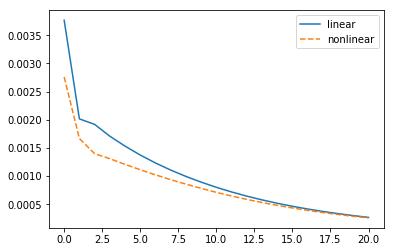

In [17]:
rho_r, sig_r = 0.9, -0.005
drstar = sig_r * rho_r ** (np.arange(T))

td_lin = hank.td_linear(G, {'rstar': drstar})
td_nonlin = hank.td_nonlinear(ss, J, ss['r'] + drstar, np.full(T, ss['Z']))

plt.plot(td_lin['C'][:21], label='linear', linestyle='-')
plt.plot(td_nonlin['C'][:21]-ss['C'], label='nonlinear', linestyle='--')
plt.legend()
plt.show()

<a id="6-determinacy"></a>

## 6. Local determinacy
Local determinacy boils down to the invertibility of the matrix $H_X.$ The steady state is a locally-stable equilibrium if and only if $H_X$ is invertible. In practice, $H_X$ is obtained numerically for a finite horizon, and thus we can never expect it to be exactly singular. Still, near-singularity of $H_X$ that gets worse with increasing the horizon $T$ is a clear indication of indeterminacy. 

As it is well-known, determinacy in the New Keynesian models requires that the interest rate rule is sufficiently responsive to inflation. Therefore, we're going to illustrate the issue by varying the parameter $\phi$ and trace its effect on $H_X.$

### 6.1 Stable case
Let's start with the the baseline calibration with $\phi=1.5$.

In [18]:
# condition number
cond = np.linalg.cond(H_X)
print(f'Condition number: {cond:.2f}')

# smallest singular value
_, s, _ = np.linalg.svd(H_X)
print(f'Smallest singular value: {s[-1]:.2f}')

Condition number: 4536.27
Smallest singular value: 0.07


### 6.2 Unstable case
Let's see what happens with $\phi=0.75$. First of all, we'll have to recompute the Jacobian. It's important to realize that $\phi$ does not affect the steady state, and affects dynamics only through the monetary block. Thus, recomputing the Jacobians of any other block, especially the heterogeneous household block, would be wasteful.

In [19]:
import copy
ss2 = copy.deepcopy(ss)
ss2['phi'] = 0.75 

# jacobians for monetary block are changing
J2_monetary = rec.all_Js(monetary, ss2, T, ['pi', 'rstar'])

In [20]:
J2 = jac.chain_jacobians(jacdicts=[J_firm, J2_monetary, J_fiscal, J_ha, J_mkt, J_nkpc],
                         inputs=unknowns+exogenous, T=T)

# assemble large Jacobian
H2_X = jac.pack_jacobians(J2, unknowns, targets, T)

This time the condition number and smallest singular value both clearly indicate indeterminacy.

In [21]:
# condition number
cond2 = np.linalg.cond(H2_X)
print(f'Condition number: {cond2:.2f}')

# smallest singular value
_, s2, _ = np.linalg.svd(H2_X)
print(f'Smallest singular value: {s2[-1]:.6f}')

Condition number: 91746446085344.27
Smallest singular value: 0.000000


Not surprisingly, if we tried to use this Jacobian to compute impulse responses, we'd fail. (We'll wrap in a try/except block to avoid a giant error message.)

In [22]:
try:
    td_nonlin = hank.td_nonlinear(ss2, J2, ss2['r'] + drstar, np.full(T, ss2['Z']), maxit=5)
except ValueError as e:
    print(e)

Max error 1.96E-01 on iteration 0
Cannot solve constrained household's problem: No convergence after 30 iterations!


/Users/mrognlie/Documents/git/sequence-jacobian/hank.py:197: RuntimeWarning: invalid value encountered in log
  Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y


In fact, it fails after the first iteration: since the Jacobian is nearly singular, using its inverse in Newton's method leads to a very large step to the next guess, which then is outside the admissible domain and leads to an error within the household routine.